# Сверточные сети
Цель этого ноутбука - знакомство со сверточными сетями и transfer learning на примере классификации картинок.  
План семинара.

* [Конволюция](#conv), [Pooling](#pooling) &mdash; базовые слои, их гиперпараметры и интуиция использования.

* Построение [сверточной нейросети](#cnn) для классификации картинок.

* Применение [аугментации](#augmentations) для улучшения качетсва.

In [ ]:
import os
import time
import glob
import requests
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline


import seaborn as sns
sns.set(palette='Set2', font_scale=1.2)
# sns.set(font_scale=1.2, style='whitegrid')

# device_num = 0
# torch.cuda.set_device(device_num)

In [ ]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

## 1. Convolution (свёртка) <a id='conv'></a>

Основные гиперпараметры:

* `in_channels` (int) - количество каналов во входном изображении

* `out_channels` (int) - количество каналов после применения свертки (кол-во ядер (фильтров), которые будут применены)

* `kernel_size` (int, tuple) - размер сверточного ядра

* `stride` (int, tuple) - шаг, с которым будет применена свертка. Значение по умолчанию 1

* `padding` (int, tuple) - добавление по краям изображения дополнительных пикселей. Значение по умолчанию 0

* `padding_mode` (string, optional) - принцип заполнения краёв. Значение по умолчанию 'zeros'

`nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, padding_mode='zeros')`
 ![](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif)

 Берем `out_channels` фильтров размера  `in_channels` x `kernel_size` x `kernel_size`. Каждым фильтром 'проходим' по изображению с шагом `stride`, поэлементно умножаем его на область изображения размером `in_channels` x `kernel_size` x `kernel_size`, складываем получившиеся поэлемнетные произведения и записываем это число в результирующий тензор. В итоге получаем `out_channels` выходных тензоров.

 **Интуиция**:
 
В FC слоях мы соединяли нейрон с каждым нейроном на предыдущем слое. Теперь нейрон соединен только с ограниченной областью выхода предыдущего слоя. Иногда эту область называют *рецептивным полем (receiptive field)* нейрона. 

Такое изменение необходимо из-за большой размерности входных данных. Например, если размер входного изображения $3 \cdot 224 \cdot 224$, то каждый нейрон в FC-слое будет содержать $3\cdot 224\cdot 224=150\:528$ параметров, что очень много. При этом мы захотим добавить нелинейности в нашу архитектуру, так что у нас будет несколько таких слоёв.



**Вопрос**

К изображению (3, 224, 224) применяют свертку `nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=2)`. 

* Какой будет размер выходного изображения? 

* Cколько у данного слоя обучаемых параметров?

*Проверяем себя.* Для этого будем использовать библиотеку torchinfo (в прошлом torchsummary). Метод summary данной библиотеки позволяет визуализировать основные характеристики нейронной сети.

In [3]:
! pip3 install torchinfo
from torchinfo import summary

Defaulting to user installation because normal site-packages is not writeable


In [5]:
model = nn.Sequential()
model.add_module('conv', nn.Conv2d(in_channels=3, out_channels=64, 
                                    kernel_size=5, stride=2, padding=2))

summary(model.to(device), (2, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [2, 64, 112, 112]         4,864
Total params: 4,864
Trainable params: 4,864
Non-trainable params: 0
Total mult-adds (M): 122.03
Input size (MB): 1.20
Forward/backward pass size (MB): 12.85
Params size (MB): 0.02
Estimated Total Size (MB): 14.07

In [201]:
3 * 64 * 5 * 5 + 64

4864

Посмотрим на то, как применение свёртки с определёнными фильтрами влияет на изображение и как будет меняться картинка в зависимости от фильтра:

In [7]:
 ! wget https://www.kotzendes-einhorn.de/blog/wp-content/uploads/2011/01/lenna.jpg

--2021-12-20 16:13:21--  https://www.kotzendes-einhorn.de/blog/wp-content/uploads/2011/01/lenna.jpg
Resolving www.kotzendes-einhorn.de (www.kotzendes-einhorn.de)... 94.130.145.107
Connecting to www.kotzendes-einhorn.de (www.kotzendes-einhorn.de)|94.130.145.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64098 (63K) [image/jpeg]
Saving to: ‘lenna.jpg’

lenna.jpg           100%[===================>]  62,60K  --.-KB/s    in 0,05s   

2021-12-20 16:13:21 (1,21 MB/s) - ‘lenna.jpg’ saved [64098/64098]



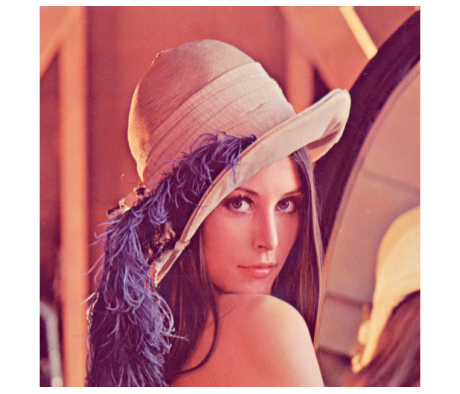

In [8]:
img = plt.imread('./lenna.jpg')

plt.figure(figsize=(12,7))
plt.imshow(img)
plt.axis("off");

Функция для инициализации весов слоя.

In [9]:
def init_conv(kernel):
    conv = nn.Conv2d(
        in_channels=3, out_channels=1, 
        kernel_size=3, bias=False
    )
    conv.weight = torch.nn.Parameter(
        torch.FloatTensor(kernel), 
        requires_grad=False
    )
    return conv

Функция для свертки изображения с одним фильтром.

In [10]:
def convolution(kernel, img, transforms):
    conv = init_conv(kernel)
    img_tensor = transforms(img)
    # Добавим батч-размерность
    res = conv(img_tensor.unsqueeze(0))
    # Избавимся от дополнительной размерности
    res = res.squeeze()
    # Пиксели имеют значения от 0 до 255
    res = (torch.clip(res, 0, 1) * 255).int()
    return res

Numpy-картинку нужно привести к torch-тензору. Кроме того, для визуализации нам нужно отобразить картинку в черно-белом цвете. Это можно сделать с помощью модуля transforms. Подробнее будет в разделе про [аугментации](#augmentations).

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),   # Переводим массив в торч-тензор
    transforms.Grayscale(),  # Делаем изображение черно-белым
])

Зададим 2 фильтра.

In [12]:
kernel_1 = torch.FloatTensor([[[
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
]]])

kernel_2 = torch.FloatTensor([[[
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
]]])

tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]])
tensor([[[[-1., -2., -1.],
          [ 0.,  0.,  0.],
          [ 1.,  2.,  1.]]]])


/home/havingfun/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:126: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


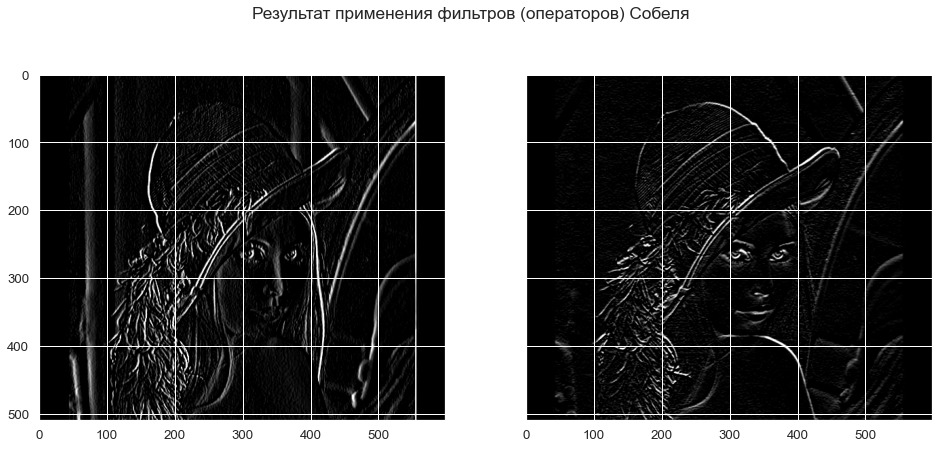

In [13]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(16, 7), 
    sharey=True, sharex=True
)

res_images = []
for fig_x, kernel in zip(ax.flatten(), [kernel_1, kernel_2]):
    print(kernel)
    res = convolution(kernel, img, transform)
    
    fig_x.imshow(res, cmap='gray')
    res_images.append(res)
plt.suptitle('Результат применения фильтров (операторов) Собеля')
plt.show()

Чем более пиксель белый, тем больше его значение. Если присмотреться, то можно заметить, как на первом результате фильтр (ядро) делает более значимыми (белыми) пиксели, соответствующие вертикальным линиям: нос, полоска справа, волосы, а на втором $-$ горизонтальным: брови, губы.

Это как раз согласуется со значениями в фильтрах (ядрах): первый вычисляет перепады значений в пикселях по вертикали, второй $-$ по горизонтали. 

С помощью этих фильтров легко прийти к методу выделения границ на изображении: поскольку каждая граница состоит из $x$ и $y$ компоненты, то используем теорему Пифагора и вычислим суммарное значение:

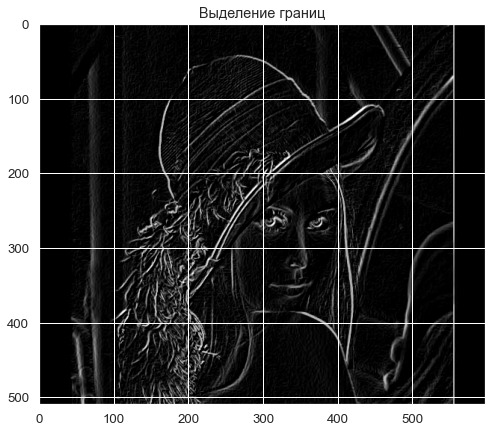

In [14]:
img_sobel = np.sqrt(res_images[0]**2 + res_images[1]**2)

plt.figure(figsize=(12,7))
plt.title('Выделение границ')
plt.imshow(img_sobel, cmap='gray')
plt.show()

Полученный фильтр также [оператором Собеля](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80_%D0%A1%D0%BE%D0%B1%D0%B5%D0%BB%D1%8F). Так, мы посмотрели как работает свертка на примере оператора Собеля. 

[На Хабре про операторы Собеля](https://habr.com/ru/post/114452/)

## 2. Pooling <a id='pooling'></a>

Основные гиперпараметры:

* `kernel_size` (int, tuple) - размер ядра

* `stride` (int, tuple) - шаг, с которым будет применен pooling. Значение по умолчанию `kernel_size`

* `padding` (int, tuple) - добавление по краям изображения нулей

Основные виды pooling-ов: 
* `MaxPooling` &mdash; берется максимум элементов, 
* `AveragePooling` &mdash; берется среднее элементов.

![](https://sun9-10.userapi.com/c854016/v854016674/22a457/mpE8Idra-5Y.jpg)

**Интуиция:**

* cнижаем размер изображения и, как следствие, вычислительную сложность;

* увеличиваем рецептивное поле на входном изображении для нейронов следующих сверточных слоев.

При этом многие исследователи ставят под сомнение эффективность pooling слоёв. Например, в статье [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806) предлагается заменить его на свертки с большим stride-ом. Также считается, что отсутствие pooling слоёв хорошо сказывается на обучении генеративных моделей, но споры ещё ведутся: [FCC-GAN: A Fully Connected and Convolutional Net
Architecture for GANs](https://arxiv.org/pdf/1905.02417.pdf)

<span style="color:red">
    
**Q48**

Применим наши знания для решения конкретной задачи.

##  3. CIFAR10

Датасет состоит из 60k картинок 32х32х3. 

50k &mdash; обучающая выборка, 10k &mdash; тестовая. 

10 классов: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.

 ![](https://sun9-72.userapi.com/c857216/v857216523/12dbca/vdSCet5LS_0.jpg)

Загружаем датасет.

In [15]:
# Загрузим часть данных для обучения
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transforms.ToTensor()
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [36]:
dataset.__getitem__(0)

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [16]:
# Разделим выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [40000, 10000])

In [17]:
# Загрузим тестовую часть данных
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transforms.ToTensor()
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [37]:
type(classes)

tuple

Инициализируем генераторы батчей:

In [18]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Пайплайн обучения.

### 3.1. Baseline

Начнем с простой линейной модели

In [19]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''

        super(MySimpleModel, self).__init__()
        # входное количество признаков = высота * ширина * кол-во каналов картинки
        # сейчас 64 нейрона в первом слое
        self.linear1 = nn.Linear(3 * 32 * 32, 64)
        # 10 нейронов во втором слое
        self.linear2 = nn.Linear(64, 10)  # логиты (logits) для 10 классов
        
    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''
        
        x = self.linear1(nn.Flatten()(x))
        x = self.linear2(nn.ReLU()(x))
        return x

#### Softmax - функция активации многоклассовой классификации

![softmax](softmax.png)

Софтмакс - это обобщение логистической функции для многомерного случая. 

Softmax применяется к $n$-мерному входному тензору, масштабируя их так, чтобы элементы $n$-мерного выходного тензора лежали в диапазоне $[0,1]$ и суммировались до $1$.

#### Функция потерь кросс-энтропия (из документации Pytorch)

Параметр $w$ - опциональный

![Фукнция потерь кросс-энтропии](CELoss.png)

In [20]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [22]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты на выходе модели
            logits = model(X_batch)
            
            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            
            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты, полученные моделью
            logits = model(X_batch)

            # Лосс на валидации
            loss = criterion(logits, y_batch.long().to(device))

            # Сохраяняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

Применим ее к нашим данным $-$ картинками из CIFAR10:

Epoch 50 of 50 took 4.850s
  training loss (in-iteration): 	1.306955
  validation loss (in-iteration): 	1.428216
  training accuracy: 			54.15 %
  validation accuracy: 			50.23 %


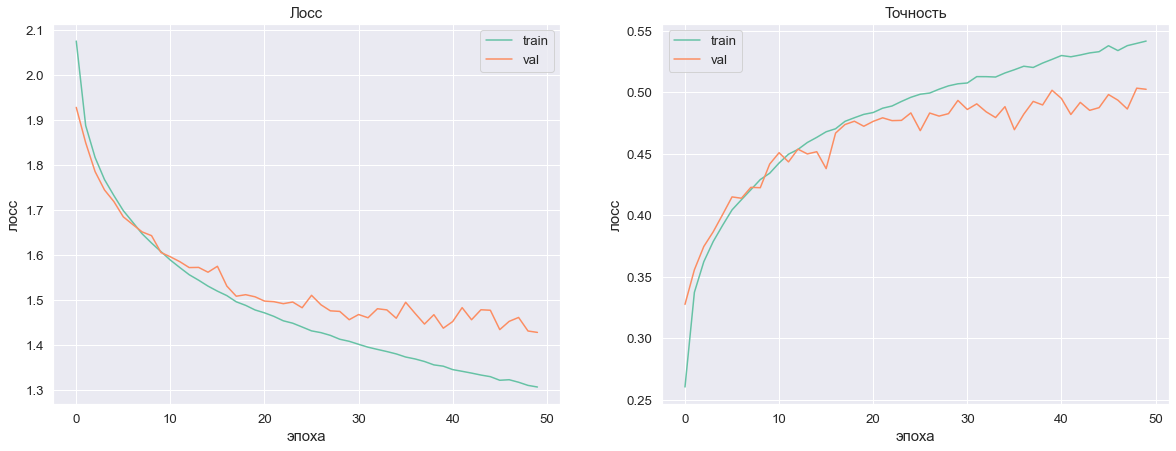

In [23]:
model = MySimpleModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=50
)

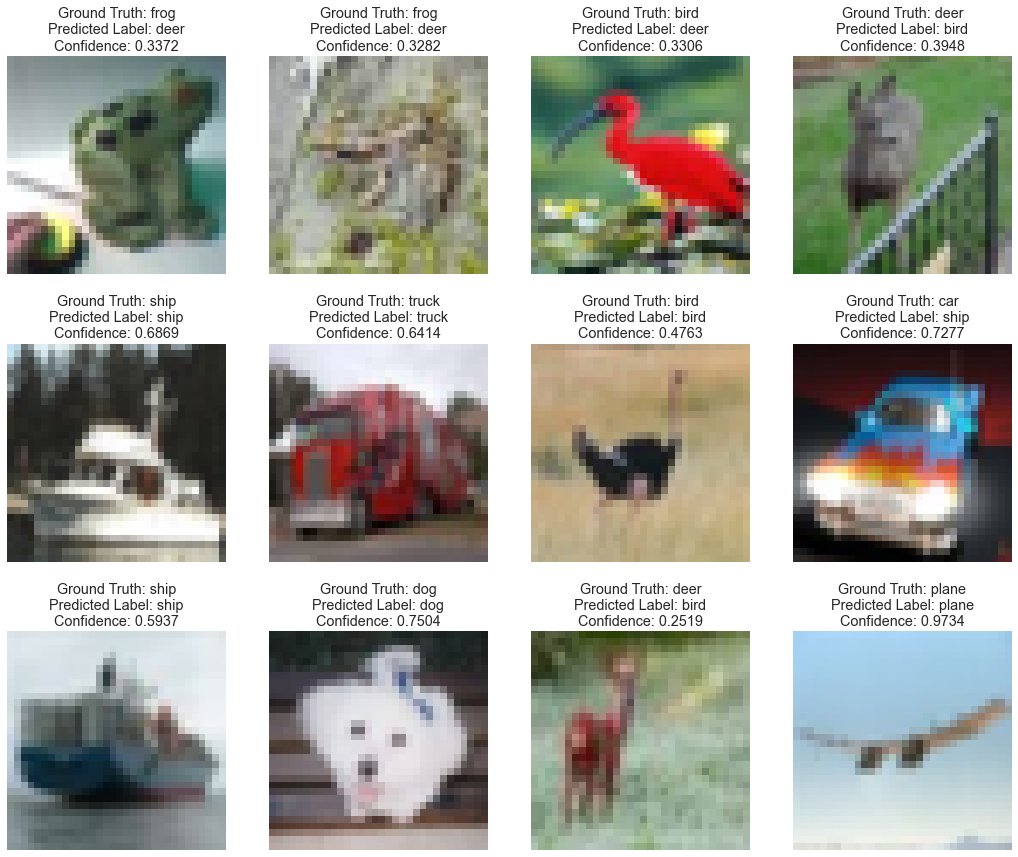

In [35]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
plt.figure(figsize=(18, 15))
for i in range(12):
    model_out = nn.Softmax(1)(model(val_dataset.__getitem__(i)[0].unsqueeze(0).to(device)))
    pred_class = classes[model_out.max(1)[1].detach().cpu().numpy()[0]]
    conf = model_out.max(1)[0].detach().cpu().numpy()[0]
    real_class = classes[val_dataset.__getitem__(i)[1]]
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.title(f'Ground Truth: {real_class}\nPredicted Label: {pred_class}\nConfidence: {conf:.4f}')
    plt.imshow(transforms.ToPILImage(mode='RGB')(val_dataset.__getitem__(i)[0]))

### 3.2. Свёрточная нейросеть <a id=cnn> </a>

*Свёрточная нейросеть / Convolutional Neural Network / CNN* &mdash; это многослойная нейросеть, имеющая в своей архитектуре свёрточные слои / Conv Layers и pooling-слои / Pool Layers.

Простые свёрточные нейросети для классификации, почти всегда строятся по следующему правилу:

$INPUT \to [[CONV -> RELU]^N \to POOL?]^M \to [FC -> RELU]^K \to FC$

"?" обозначает опциональные слои.

![](https://sun9-64.userapi.com/c856028/v856028087/1eae7b/GrKeqELsvWM.jpg)

Подробнее:

1. Входной слой (batch картинок HxWxC)

2.  $M$  блоков ($M  \ge  0$) из свёрток и pooling-ов. Все эти  $M$  блоков вместе называют *feature extractor* свёрточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков на основе тех, которые подаются

 

3.  $K$  штук FullyConnected-слоёв с активациями. Эту часть из  $K$  FC-слоёв называют *classificator*, поскольку эти слои отвечают непосредственно за предсказание нужного класса.

  *Замечание*:  Pooling layer можно пропустить и не включать в архитектуру, но при этом он снижает размерность, а следовательно и вычислительную сложность, а также помогает бороться с переобучением

**Пример, почему 3 свертки 3х3 экономнее по памяти, чем одна свертка 7x7:**

Предположим, что входное изображение имеет $C$ каналов, и что количество фильтров в сверточных слоях тоже равно $C$.

1. **[CONV((3, 3)) -> RELU]^3**

  Количество параметров: $3(C(C*3*3)) = 27C^2$
    
  Рецептивное поле первой свертки на входном изображении: $3\times3$
    
  Рецептивное поле второй свертки на выходе первой свертки: $3\times3$, и, следовательно, $5\times5$ на входном изображении.
    
  Аналогично рецептивное поле третьей свертки, а значит и всего блока на входном изображении: $7\times7$.
    

2. **[CONV((7, 7)) -> RELU]^1**

  Количество параметров: $C(C*7*7) = 49C^2$
    
  Рецептивное поле на входном изображении: $7\times7$
    
**Вывод:** Первый вариант формирует более сложные признаки из-за нелинейностей, при этом имеет меньше параметров и такое же рецептивное поле на входном изображении.



#### Дополнительные полезные слои `Dropout` и `BatchNorm`

* `Dropout` - отключает некоторые параметры случайным образом, позволяет бороться с переобучением, можно интерпретировать как обучение ансамбля моделей.
* `BatchNorm` нормализует данные между слоями (в рамках батча), делает веса на более поздних слоях менее чувствительными к изменениям весов на начальных слоях. Таким образом `BatchNorm` позволяет сделать нейросеть более стабильной при изменении распределения входных данных.

Из [документации PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html):
![](./batch_norm.png)

**Вопрос**: посмотрите на следующую нейросеть и укажите на некорректные шаги в реализации.


In [222]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(3, 2048, kernel_size=5, stride=2, padding=3))
model.add_module('mp1', nn.MaxPool2d(7))
model.add_module('conv2', nn.Conv2d(2048, 64, kernel_size=3))
model.add_module('mp2', nn.MaxPool2d(2))
model.add_module('bn1', nn.BatchNorm2d(64))
model.add_module('dp1', nn.Dropout(0.5))
model.add_module('relu1', nn.ReLU())

model.add_module('conv3', nn.Conv2d(64, 128, kernel_size=(20, 20)))
model.add_module('mp3', nn.MaxPool2d(2))
model.add_module('conv4', nn.Conv2d(128, 256, kernel_size=(20, 20)))

model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(1024, 512))
model.add_module('fc2', nn.Linear(512, 10))
model.add_module('dp2', nn.Dropout(0.05))

> Подсказка:

*(нужно дважды кликнуть на ячейку)*
<style>
div.input {
    
* нет активаций после сверток (свертка по своей сути - линейное преобразование и активации нужны, чтобы добавить нелинейность)

* слишком много выходных каналов в `conv1`. Увеличили число параметров слишком сильно: мы потратим гораздо больше времени на обучение при этом получив много повторяющихся сверток

* теряем слишком много информации в `mp1`, размер ядра нужно уменьшить

* теряем слишком много информации в `dp1`

* слишком большой `kernel_size` в `conv3` и `conv4`, этот код не сможет скомпилироваться, потому что размер изображения будет меньше, чем `kernel_size`

* два линейных слоя подряд `fc1` и `fc2` без активации между ними можно заменить одним синейным слоем

* `droupout` в конце просто зануляет часть выходов к лоссу, а не выключает связи между нейронами. Тем самым мы теряем уже выученную информацию, а не боремся с переобучением.
display:none;
}
</style>

Исправим все ошибки и обучим полученную сверточную сеть.



In [223]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3) 
        self.mp1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(32)
        self.droupout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.mp2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(64)
        self.droupout2 = nn.Dropout(0.3)
        self.relu2 = nn.ReLU()
        
        self.flatten = nn.Flatten()
        self.fc3 = nn.Linear(2304, 512)
        self.droupout3 = nn.Dropout(0.3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(512, 10)
                                
    def forward(self, x):
        layer1 = self.mp1(self.conv1(x))
        layer1 = self.relu1(self.droupout1(self.bn1(layer1)))
        
        layer2 = self.mp2(self.conv2(layer1))
        layer2 = self.relu2(self.droupout2(self.bn2(layer2)))
        
        out = self.flatten(layer2)
        out = self.relu3(self.droupout3(self.fc3(out)))
        out = self.fc4(out)
        return out

In [224]:
model = SimpleConvNet().to(device)
print('Количество параметров модели', sum(p.numel() for p in model.parameters() if p.requires_grad))

Количество параметров модели 1204874


Epoch 50 of 50 took 10.383s
  training loss (in-iteration): 	0.464254
  validation loss (in-iteration): 	0.684233
  training accuracy: 			83.88 %
  validation accuracy: 			76.59 %


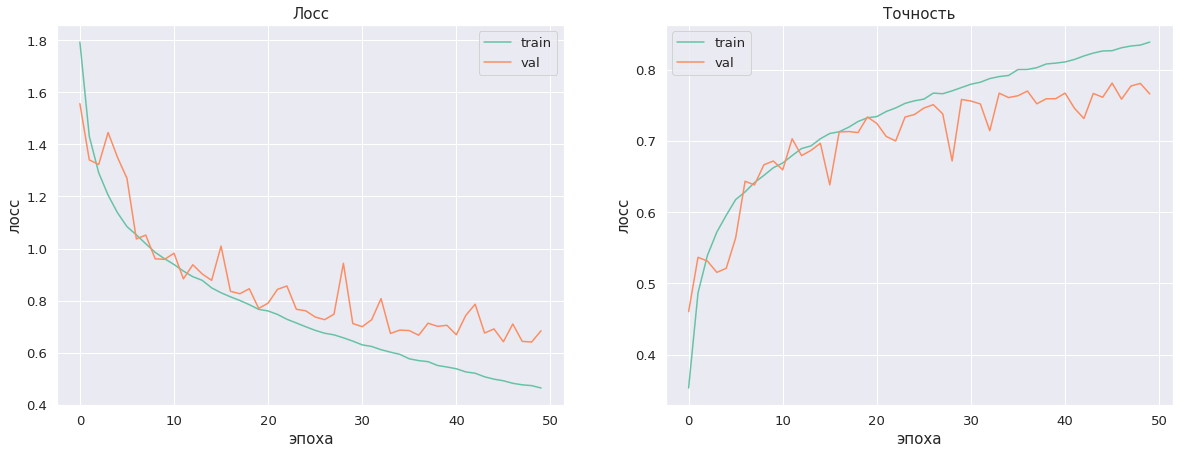

In [25]:
model = SimpleConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=50
)

> Сравните полученное качество с тем, что мы получили ранее для не свертосной сетки.

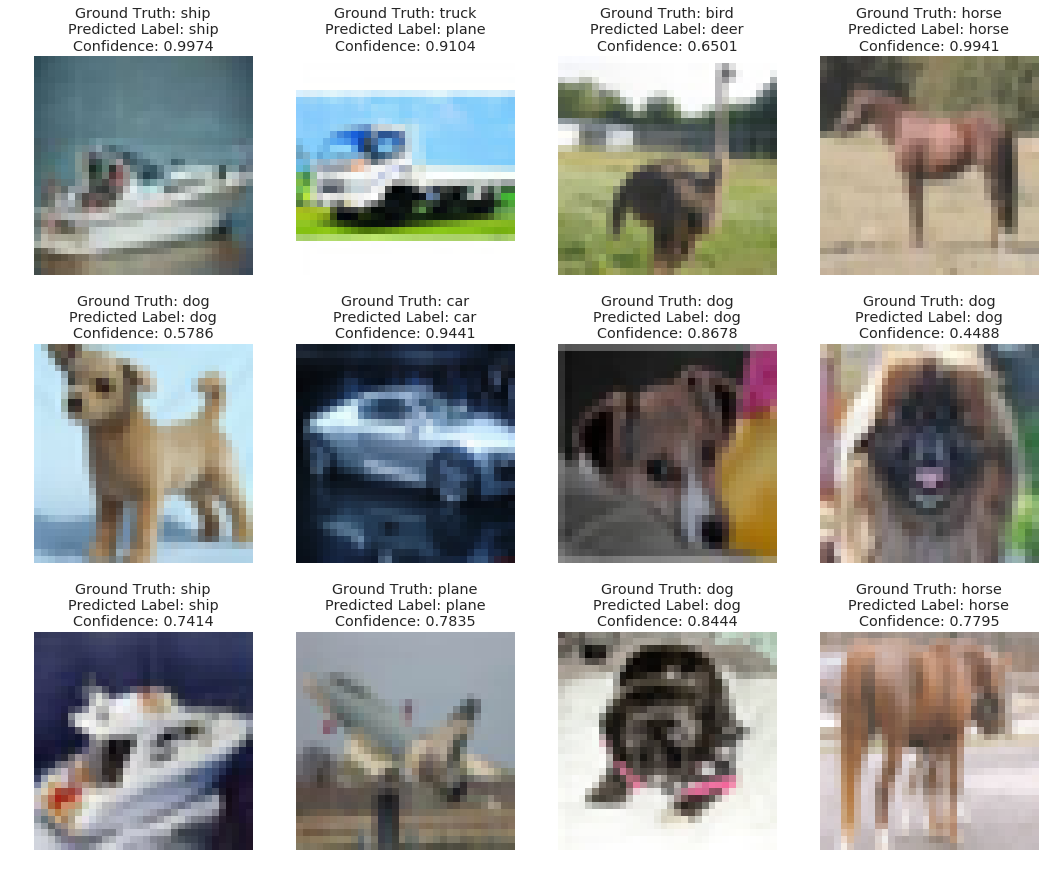

In [26]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
plt.figure(figsize=(18, 15))
for i in range(12):
    model_out = nn.Softmax(1)(model(val_dataset.__getitem__(i)[0].unsqueeze(0).to(device)))
    pred_class = classes[model_out.max(1)[1].detach().cpu().numpy()[0]]
    conf = model_out.max(1)[0].detach().cpu().numpy()[0]
    real_class = classes[val_dataset.__getitem__(i)[1]]
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.title(f'Ground Truth: {real_class}\nPredicted Label: {pred_class}\nConfidence: {conf:.4f}')
    plt.imshow(transforms.ToPILImage(mode='RGB')(val_dataset.__getitem__(i)[0]))

## 4. Аугментация <a id='augmentations'> </a>

![](https://sun9-5.userapi.com/c857216/v857216818/1815e6/OxQ8e3-o0oU.jpg)

**Дополнение данных / Аугментация данных / Data augmentations** &mdash; это метод, направленный на увеличение размеров обучающей выборки. Дополнение обучающей выборки разнообразными, "хорошими" и "плохими" примерами, позволяет получить модель более устойчивую на тестовых данных, так как для неё в тестовых данных будет меньше "неожиданностей".

Благодаря модулю `torchvision.transforms` агументации можно делать очень просто. Про все реализованные в библиотеке преобразования можно почитать [здесь](https://pytorch.org/docs/stable/torchvision/transforms.html). Мы рассмотрим наиболее распространенные классы аугментаций.

* `RandomAffine(degrees, translate=None, scale=None, shear=None, interpolation=<InterpolationMode.NEAREST: 'nearest'>, fill=0, fillcolor=None, resample=None)` &mdash; **случайное афинное преобразование** с сохранением центра. `degrees` &mdash; максимальный градус вращения. `translate` &mdash; смещение. `scale` &mdash; масштаб. Подробнее в документации.


* `ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)` &mdash; *случайное* изменение **яркости** / brightness, **контраста** / contrast, **насыщенности** / saturation и **тонов** / hue цветов. Если на вход приходит torch.Tensor, то его размерность дожна быть `[..., 3, H, W]`. Если PIL.Image, то без альфа-канала. Каждый из параметров может быть быть задан в виде float числа: param, или пары float чисел: min, max. Значение парметра выбирается случайно из отрезка `[1 - param, 1 + param]` или `[min, max]` для brightness, contrast, saturation. Значение парметра должно быть нотрицательным. Значение парметра hue выбирается случайно из отрезка `[-hue, hue]` или `[min, max]`. При этом значение 0<= `hue <= 0.5` or `-0.5 <= min <= max <= 0.5`.  


* `CenterCrop(size)` &mdash; вырезает **прямоугольную область** размером `size[0] x size[1]`, если size задан туплом, если `size` задан числом &mdash; `size x size` **из центра картинки**.


* `GaussianBlur(kernel_size, sigma)` &mdash; *случайное* **гауссовское размытие изображения**. `kernel_size` &mdash; размер гауссовского ядра. `sigma` &mdash; стандартное отклонение. `sigma` может быть задано в виде чила, тогда парметр фиксирован, или в виде тупла in, max, тогда оно выбирается случайно из отрезка `[min, max]`.  


* `Grayscale(num_output_channels=1)` и `RandomGrayscale`(p=0.1) &mdash; неслучайная и *случайная* **трансформации картинки в ч/б формат**. Grayscale имеет парметр `num_output_channels`, который означет количество каналов на выходе, он может быть равен 1 или 3. RandomGrayscale имеет парметр p, который равен вероятности применения преобразования. Тензор на выхоже будет иметь столько же каналов, сколько тензор на входе.   


* `Normalize(mean, std, inplace=False)` &mdash; **нормализация тензора картинки** с заданными средним и отклонением для каждого канала. То есть `mean = (mean[1], ..., mean[n])`, `std = (std[1], ..., std[n])`, где `n` &mdash; количество каналов. Не поддерживает PIL.Image формат!   


* `RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=<InterpolationMode.BILINEAR: 'bilinear'>)` &mdash; **случайное обрезание картинки** со случайным выбором размера и соотношения сторон и последующим **увеличеним картинки до первонального размера**.  

* `Resize(size, interpolation=<InterpolationMode.BILINEAR: 'bilinear'>)`  &mdash; **изменение размеров кратинки**. Если `size` задан числом, то наименьшая из размерностей картинки приобретает размер `size`. Иначе, если размер задан парой, то размер картинки становится равным `size[0] x size[1]`. 

Для того, чтобы получить преобразование, которого нет в модуле torchvision.transforms можно использовать `Lambda` преобразование. Например, получить гауссовский шум на изображении можно так:
```
Lambda(lambda x : x + torch.randn_like(x))
```

Выше перечисленные трансформации применяются к данным типа PIL.Image или torch.Tensor,на выходе выдают соотвествующий формат. Для того, чтобы в через тарнсформации получить PIL.Image, можно использовать класс `ToPILImage`, для того, чтобы получить torch.Tensor &mdash; `ToTensor`. Эти классы в методе forward могут использовать torch.Tensor, np.ndarray и PIL.Image, np.ndarray соотвественно.

Чтобы объединить несколько трансформаций можно использовать `Compose`(transforms), где transforms &mdash; список из объектов коассов преобразований.

Применим несколько случайных преобразований к картинкам, и тем самым расширим нашу выборку. Так как `CIFAR` выдает `PIL.Image`, то необходимо применить преобразование `ToTensor`.

In [191]:
from torchvision import transforms

# Набор аугментаций при обучении
transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.9, contrast=0.9, saturation=0.9),
    transforms.RandomAffine(degrees=30),
    transforms.RandomResizedCrop(size=(32, 32)),
])

# Набор аугментаций при валидации и тестировании
transform = transforms.Compose([
    transforms.ToTensor(),
])

Загружаем данные.

In [192]:
# Данные для обучения и валидации
dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

# Разделили выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [40000, 10000])

# Данные для тестирования
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


Инициализируем даталоадеры:

In [193]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Добавим трансформаций во время обучения.

In [194]:
def train_with_aug(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)

            # Применяем аугментацию
            X_batch = transform_train(X_batch)

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты на выходе модели
            logits = model(X_batch)
            
            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            
            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты, полученные моделью
            logits = model(X_batch)

            # Лосс на валидации
            loss = criterion(logits, y_batch.long().to(device))

            # Сохраяняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

Обучим нейросеть на новых данных.

Epoch 50 of 50 took 9.935s
  training loss (in-iteration): 	1.486840
  validation loss (in-iteration): 	1.461063
  training accuracy: 			47.14 %
  validation accuracy: 			49.63 %


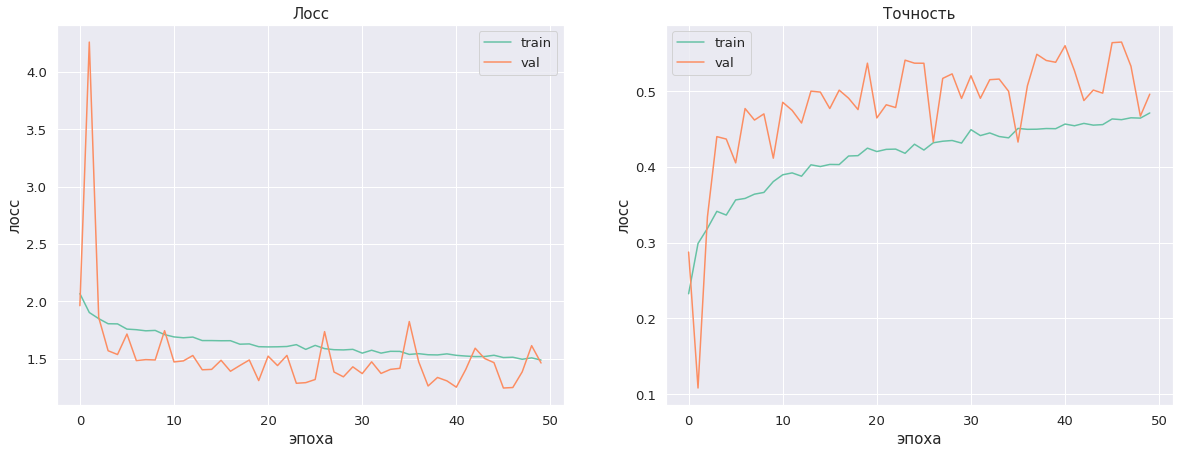

In [195]:
model = SimpleConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train_with_aug(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=50
)

Каждую эпоху для каждого изображения выбирается случайная трансформация. Таким образом каждую эпоху нейросеть обучается на одном и том же количестве изображений, но они каждый раз разные.

> Сравните, как аугментация влияет на качество на обучении и на валидации.

Запустим еще 50 эпох.

Epoch 50 of 50 took 9.988s
  training loss (in-iteration): 	1.418952
  validation loss (in-iteration): 	1.283796
  training accuracy: 			49.75 %
  validation accuracy: 			55.92 %


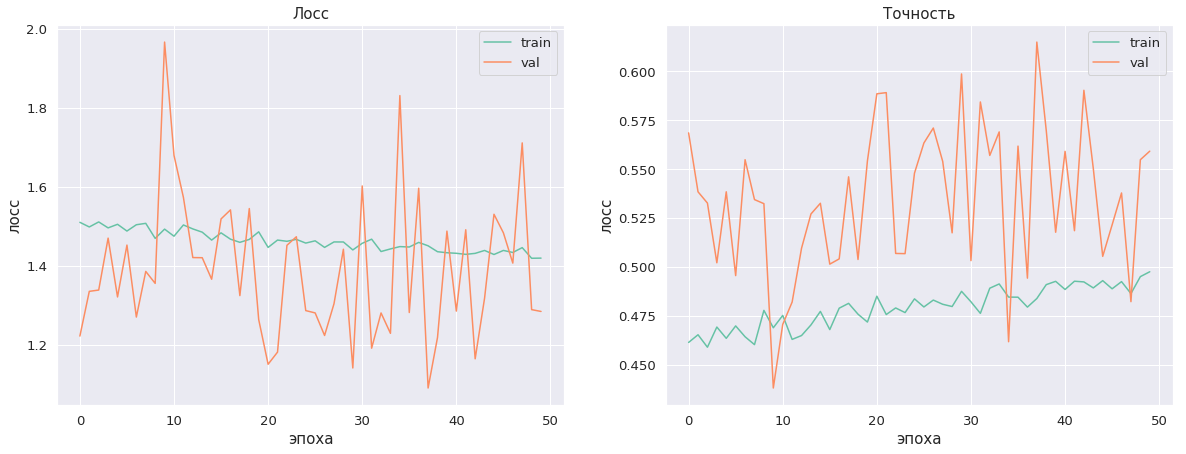

In [32]:
model, history = train_with_aug(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=50
)

---

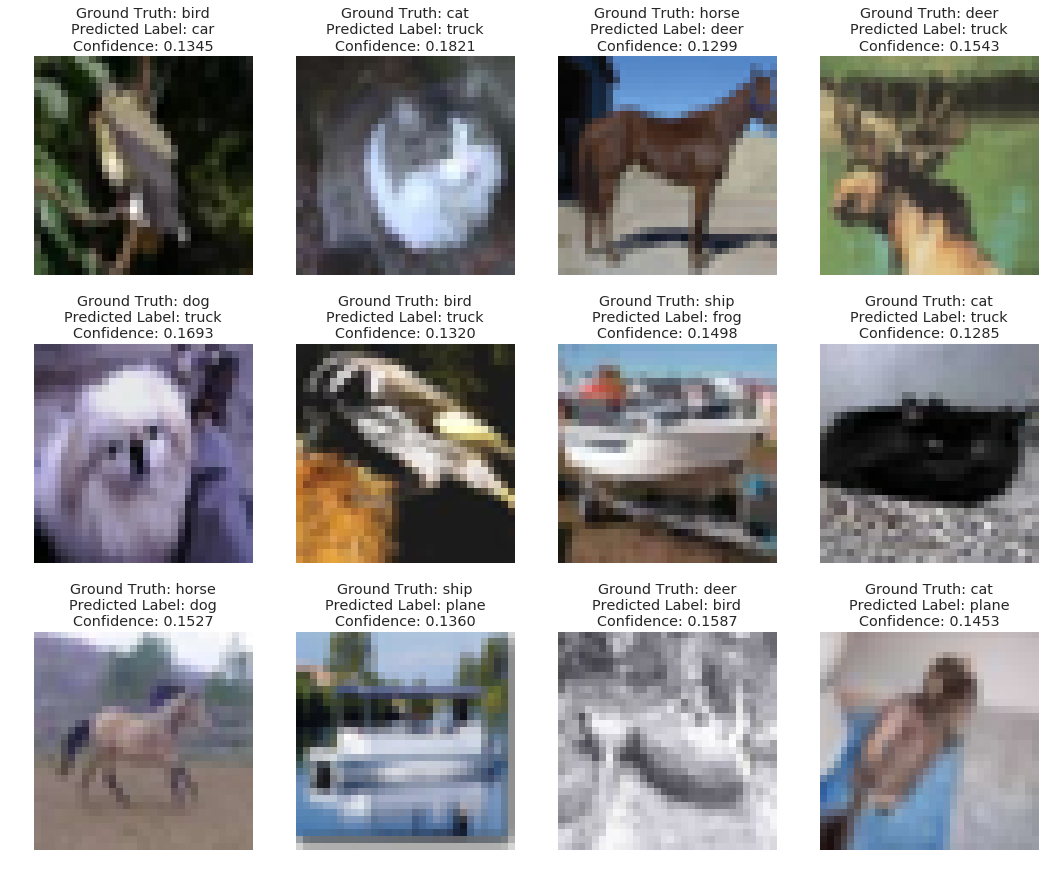

In [225]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
plt.figure(figsize=(18, 15))
for i in range(12):
    model_out = nn.Softmax(1)(model(val_dataset.__getitem__(i)[0].unsqueeze(0).to(device)))
    pred_class = classes[model_out.max(1)[1].detach().cpu().numpy()[0]]
    conf = model_out.max(1)[0].detach().cpu().numpy()[0]
    real_class = classes[val_dataset.__getitem__(i)[1]]
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.title(f'Ground Truth: {real_class}\nPredicted Label: {pred_class}\nConfidence: {conf:.4f}')
    plt.imshow(transforms.ToPILImage(mode='RGB')(val_dataset.__getitem__(i)[0]))

#### Карты признаков

In [187]:
num_item = 100

label = classes[val_dataset.__getitem__(num_item)[1]]
# входной тензор 
inp_ten = val_dataset.__getitem__(num_item)[0].unsqueeze(0).to(device)

# подадим его в первый слой сети
feat_map_1 = model.relu1(model.mp1(model.conv1(inp_ten)))

# # подадим его во второй слой сети
feat_map_2 = model.relu2(model.mp2(model.conv2(feat_map_1)))

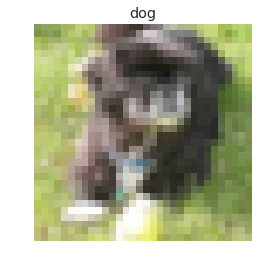

In [188]:
plt.title(label)
plt.axis('off')
plt.imshow(transforms.ToPILImage(mode='RGB')(inp_ten[0]))

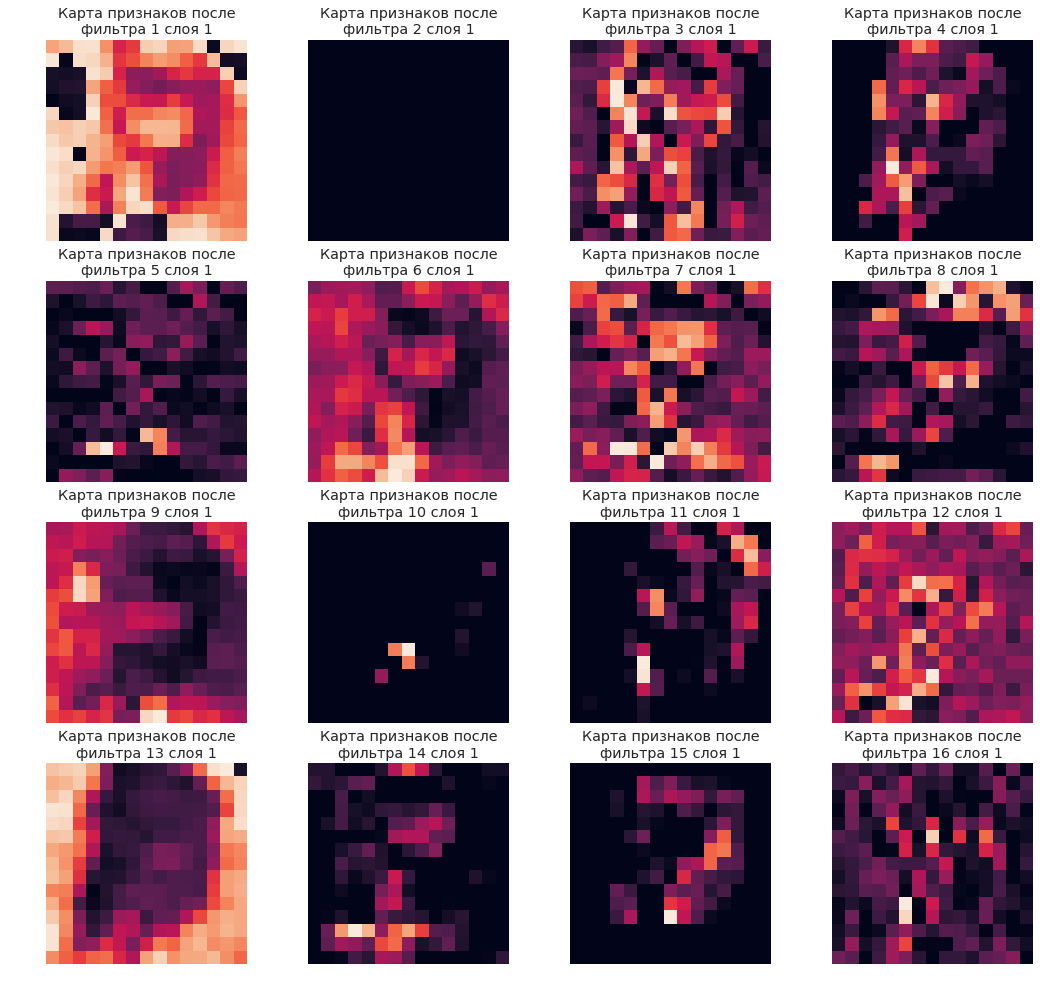

In [189]:
# Карты признаков после первого слоя
plt.figure(figsize=(18, 17))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.axis('off')
    plt.title(f'Карта признаков после\nфильтра {i + 1} слоя 1')
    plt.imshow(transforms.ToPILImage(mode='L')(feat_map_1[0][i]))

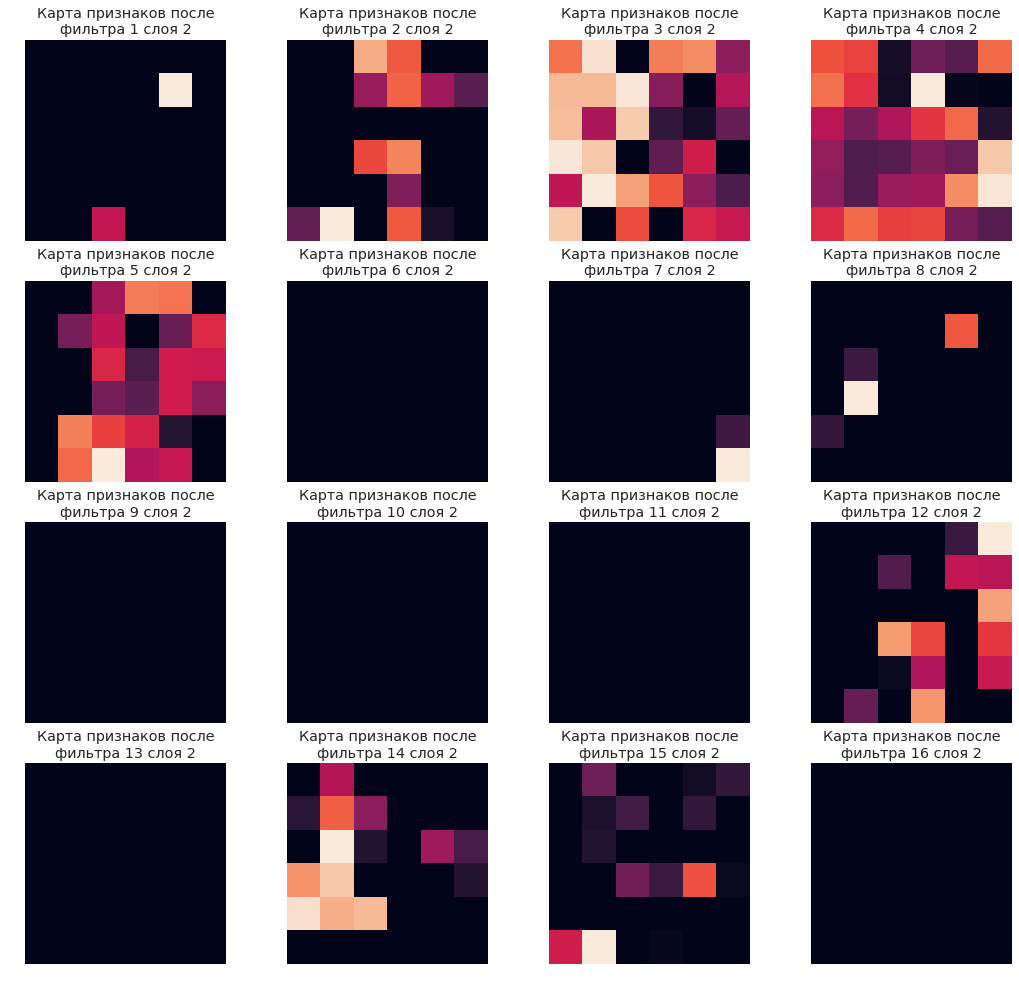

In [190]:
# Карты признаков после второго слоя
plt.figure(figsize=(18, 17))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.axis('off')
    plt.title(f'Карта признаков после\nфильтра {i + 1} слоя 2')
    plt.imshow(transforms.ToPILImage(mode='L')(feat_map_2[0][i]))

In [79]:
# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
# define dataset
X, y = make_classification(n_samples=10000, weights=[0.99], flip_y=0)
# summarize class distribution
print(Counter(y))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(list(X), list(y))
# summarize class distribution
print(Counter(y_over))

Counter({0: 9900, 1: 100})
Counter({0: 9900, 1: 9900})


In [43]:
type(X)

numpy.ndarray